In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import os

# Set the dataset path
data_path = '/kaggle/input/culane-f1/CULane/'

# Set the correct path
dirMain = os.listdir('/kaggle/input/culane-f1/CULane/driver_161_90frame')
myimages = []
myannot = []

for folder in sorted(dirMain):
    counter_jpg = 0
    counter_txt = 0
    folder_path = os.path.join('/kaggle/input/culane-f1/CULane/driver_161_90frame', folder)
    for file in sorted(os.listdir(folder_path)):
        if '.jpg' in file:
            image_name = file.split(".")
            image1_name = image_name[0]
            text1_name = image1_name + '.lines.txt'
            file1_name = file
            counter_jpg += 1
            for file in sorted(os.listdir(folder_path)):
                if text1_name in file:
                    if os.stat(os.path.join(folder_path, file)).st_size == 0:
                        continue
                    myannot.append(os.path.join(folder_path, file))
                    myimages.append(os.path.join(folder_path, file1_name))
                    counter_txt += 1

print(f"Loaded {len(myimages)} images and {len(myannot)} annotations.")

# Build image tensors
N_train_image = 10000
X_data = []
Y_data = []

for j in tqdm(range(len(myannot))):
    lines = []
    try:
        with open(myannot[j], 'r') as f:
            data = f.readlines()
            lines = [line.split() for line in data]
            lines = [[int(float(i)) for i in line] for line in lines]
            lines = [[(line[i], line[i + 1]) for i in range(0, len(line), 2)] for line in lines]
            lines = [line for line in lines if len(line) != 1]
            new_lines = [*lines]
            lines = []
            for line in new_lines:
                try:
                    x1 = line[0][0]
                    y1 = line[0][1]
                    x2 = line[-1][0]
                    y2 = line[-1][1]

                    if x2 == x1:
                        continue

                    m = (y2 - y1) / (x2 - x1)
                    b = y1 - m * x1

                    lines.append((x1, y1, x2, y2, m, b))
                except Exception as e:
                    print(f"Error processing line in {myannot[j]}: {e}")
                    continue
            label = np.zeros((5000, 5000))
            for line in lines:
                x1, y1, x2, y2, m, b = line
                x = np.arange(x1, x2, 1 if x2 > x1 else -1)
                y = m * x + b
                y = np.array(y, dtype=int)
                label[y, x] = 255
            label = label[:590, :1640]
            label = np.array(Image.fromarray(label).resize((328, 118)))
            Y_data.append(label)
            myimages[j] = plt.imread(myimages[j])
            myimages[j] = np.array(Image.fromarray(myimages[j]).resize((328, 118)))
            X_data.append(myimages[j])
    except Exception as e:
        print(f"Error loading file {myannot[j]}: {e}")
    if j == N_train_image - 1:
        break

if len(X_data) == 0 or len(Y_data) == 0:
    print("Error: No training data loaded.")
else:
    print(f"Loaded training data: {len(X_data)} images and {len(Y_data)} labels.")

Y_data = np.array(Y_data)
Y_data = np.expand_dims(Y_data, -1)
X_data = np.array(X_data)

# Convert the index array to a TensorFlow-supported tensor type
X_data = tf.convert_to_tensor(X_data, dtype=tf.float32)
Y_data = tf.convert_to_tensor(Y_data, dtype=tf.float32)

# Ensure the index array is also a TensorFlow-supported tensor type
index_tensor = tf.convert_to_tensor(np.arange(X_data.shape[0]), dtype=tf.int32)  # Example index

# Use TensorFlow tensors for indexing
X_data = tf.gather(X_data, index_tensor)  # Use gather for tensor indexing
Y_data = tf.gather(Y_data, index_tensor)

X_data = X_data[:, 54:, :, :]  # Slicing operation still works
Y_data = Y_data[:, 54:, :, :]

print("Y_data shape:", Y_data.shape)
print("X_data shape:", X_data.shape)

label_max = tf.reduce_max(Y_data)
Y_data = Y_data / label_max
X_data = X_data / 255

print("Max value in Y_data after normalization:", tf.reduce_max(Y_data))
print("Max value in X_data after normalization:", tf.reduce_max(X_data))

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_data.numpy(), Y_data.numpy(), test_size=0.2, random_state=42)


Loaded 16210 images and 16210 annotations.


 62%|██████▏   | 9999/16210 [08:15<05:07, 20.19it/s]


Loaded training data: 10000 images and 10000 labels.
Y_data shape: (10000, 64, 328, 1)
X_data shape: (10000, 64, 328, 3)
Max value in Y_data after normalization: tf.Tensor(1.0, shape=(), dtype=float32)
Max value in X_data after normalization: tf.Tensor(1.0, shape=(), dtype=float32)


In [2]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dropout, UpSampling2D, Conv2D, BatchNormalization, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Build the U-Net model
def unet_with_pretrained_backbone(input_size=(64, 328, 3), dropout_rate=0.5, pretrained=True):
    if pretrained:
        backbone = MobileNetV2(input_shape=input_size, include_top=False, weights='imagenet')
    else:
        backbone = MobileNetV2(input_shape=input_size, include_top=False, weights=None)
    
    inputs = Input(input_size)
    x = backbone(inputs)
    
    f = 128
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(f, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(f//2, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(f//4, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)
    outputs = Lambda(lambda x: tf.image.resize(x, size=(64, 328)))(outputs)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

# Define Dice coefficient for evaluating model performance
def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true), -1) + tf.reduce_sum(tf.square(y_pred), -1) + smooth)

# Define Dice coefficient loss function
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Define a combined loss function using Dice coefficient loss and binary cross-entropy
def combined_loss(y_true, y_pred):
    y_pred = tf.image.resize(y_pred, tf.shape(y_true)[1:3])
    return dice_coef_loss(y_true, y_pred) + BinaryCrossentropy()(y_true, y_pred)

# Create and compile the model
model = unet_with_pretrained_backbone(input_size=(64, 328, 3), dropout_rate=0.5)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=combined_loss, metrics=[dice_coef, 'accuracy'])

# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

# Learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
                    validation_data=(X_test, Y_test),
                    epochs=50,
                    callbacks=[lr_scheduler])


/tmp/ipykernel_36/1166731764.py:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = MobileNetV2(input_shape=input_size, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724724839.115024     109 service.cc:145] XLA service 0x7d8594003fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724724839.115117     109 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/250 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.4360 - dice_coef: 0.7903 - loss: 1.0592   

I0000 00:00:1724724873.559360     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 131s 257ms/step - accuracy: 0.5685 - dice_coef: 0.8161 - loss: 0.9188 - val_accuracy: 0.1980 - val_dice_coef: 0.6571 - val_loss: 2.5257 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 214ms/step - accuracy: 0.8420 - dice_coef: 0.8599 - loss: 0.7257 - val_accuracy: 0.1900 - val_dice_coef: 0.6349 - val_loss: 3.6529 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 215ms/step - accuracy: 0.8944 - dice_coef: 0.8896 - loss: 0.5972 - val_accuracy: 0.3090 - val_dice_coef: 0.7031 - val_loss: 2.5308 - learning_rate: 1.0000e-04
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 213ms/step - accuracy: 0.9050 - dice_coef: 0.9244 - loss: 0.4436 - val_accuracy: 0.4979 - val_dice_coef: 0.7894 - val_loss: 1.2763 - learning_rate: 1.0000e-04
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 218ms/step - accuracy: 0.9001 - dice_coef: 0.9509 - loss: 0.3260 - val_accuracy: 0.6507 - val_dice_coef: 0.8641 - val_loss: 0.7464 - learning_rate: 1.0000

In [3]:
def evaluate_model(X_test, Y_test, model, batch_size=32):
    all_predictions = []
    all_labels = []
    running_loss = 0.0
    total_batches = int(np.ceil(len(X_test) / batch_size))
    
    for i in range(total_batches):
        batch_start = i * batch_size
        batch_end = min((i + 1) * batch_size, len(X_test))
        batch_images = X_test[batch_start:batch_end]
        batch_labels = Y_test[batch_start:batch_end]

        predictions = model.predict(batch_images)

        y_pred_binary = (predictions > 0.5).astype(int)
        y_true_binary = (batch_labels > 0.5).astype(int)

        # Evaluate the loss for the current batch
        loss = model.evaluate(batch_images, batch_labels, verbose=0)
        
        # If `model.evaluate` returns a list, extract the first element (loss value)
        if isinstance(loss, list):
            running_loss += loss[0]
        else:
            running_loss += loss

        all_predictions.extend(y_pred_binary.flatten())
        all_labels.extend(y_true_binary.flatten())
    
    avg_loss = running_loss / total_batches
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
    
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
    
    return avg_loss, accuracy, precision, recall, f1


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━

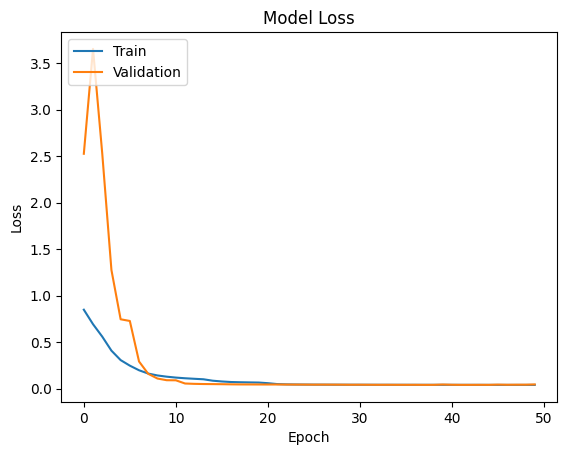

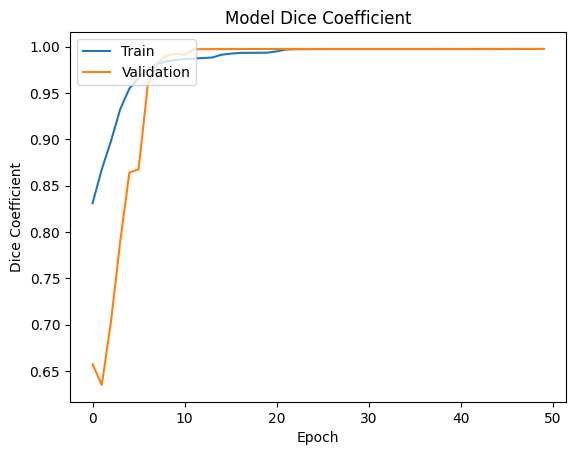

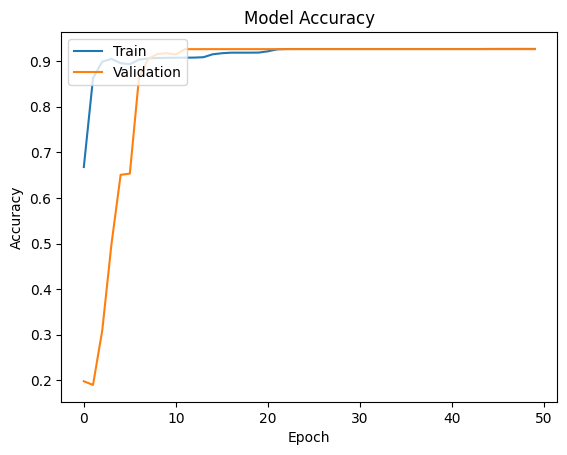

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [4]:
# Evaluate the model using the evaluation function
avg_loss, accuracy, precision, recall, f1 = evaluate_model(X_test, Y_test, model)

print(f"Loss: {avg_loss}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Predict and evaluate the model
predictions = model.predict(X_test)
